# Init

In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy
import sys
from pathlib import Path


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
descriptor_candidates = [
    Path("examples/selectiveRIP/Descriptors/1port.yaml"),
    Path("Descriptors/1port.yaml"),
]
descriptor_path = next((p for p in descriptor_candidates if p.exists()), descriptor_candidates[0])
setup = DeviceSetup.from_yaml(filepath=str(descriptor_path.resolve()), server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [3,4,5] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

project_root = next(
    (p for p in [Path.cwd(), *Path.cwd().parents] if (p / "qpu_types").exists() and (p / "helper.py").exists()),
    Path.cwd(),
)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260226-1131_readout_optv2


In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.26 11:49:01.313] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/Research/03_Code/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.26 11:49:01.314] INFO    VERSION: laboneq 25.10.3
[2026.02.26 11:49:01.315] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.26 11:49:01.351] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.26 11:49:01.398] INFO    Configuring the device setup
[2026.02.26 11:49:01.437] INFO    The device setup is configured


In [3]:
qubits[0].readout_parameters()

('measure',
 {'amplitude': 0.24000000000000002,
  'length': 1.8e-06,
  'pulse': {'function': 'GaussianSquare',
   'risefall_sigma_ratio': 3.0,
   'sigma': 0.03}})

In [4]:
# from helper import adjust_amplitude_for_output_range, calculate_power
# #calculate_power(output_dbm=-30, amplitude=0.021,attenuation=[]) 
# a = qubits[2].parameters.ge_drive_amplitude_pi2
# qubits[2].parameters.ge_drive_amplitude_pi2 = adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= a, new_output_dbm=10) 


# print(qubits[2].parameters.ge_drive_amplitude_pi2)


# Rabi amplitude

In [ ]:
from experiments import amplitude_rabi
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
amplitudes = np.linspace(0.0, 1.0,101)
print(q.transition_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.use_cal_traces(True)
options.count(1024)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

In [ ]:
qubits[2].parameters.ge_drive_amplitude_pi2 = 2 * qubits[2].parameters.ge_drive_amplitude_pi2
#qubits[1].parameters.resonance_frequency_ge = 4.538062e9

# Ramsey

In [ ]:
from experiments import ramsey

q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.4e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(False)
options.count(256)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

# X180

In [ ]:
from experiments import amplitude_fine
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,12) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

# X90

In [ ]:
qubits[0].transition_parameters()

In [ ]:
from experiments import amplitude_fine
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,16)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)


#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options,
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

In [ ]:
import importlib
from experiments import drag_q_scaling
importlib.reload(drag_q_scaling)

###############################################################
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = drag_q_scaling.experiment_workflow.options()
options.update(False)
options.count(1024)
# workflow.show_fields(options)
###################################################################
drag = drag_q_scaling.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    q_scalings=np.linspace(-0.05, 0.05, 11),
    mode="hybrid",
    fine_span=0.02,
    fine_points=9,
    temporary_parameters = temporary_parameters, 
)

drag_result = drag.run()

# RB

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[2]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

# IQ Clouds

In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
q_temp_pars.readout_integration_length=1.0e-6
temporary_parameters[q.uid] = q_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    temporary_parameters=temporary_parameters,
    options=options,
).run()


In [ ]:
qubits[0].readout_parameters()
qubits[0].readout_integration_parameters()

# Multiplexed IQ Clouds

In [ ]:
qubits[0].parameters.readout_integration_delay
#qubits[2].parameters.readout_length


#qubits[2].parameters.readout_range_in =0 


In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]
qq = qubits[2]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
qq_temp_pars = deepcopy(qq.parameters)

q_temp_pars.readout_integration_delay = 180e-9
qq_temp_pars.readout_integration_delay= 180e-9
q_temp_pars.readout_length = 1.6e-6
qq_temp_pars.readout_length = 1.6e-6
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[qq.uid] = qq_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q,qq],
    temporary_parameters=temporary_parameters,
    options=options,
).run()




# Linear Phase Delay

In [ ]:
from experiments import linear_phase_delay


#######################################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

#######################################################################
options = linear_phase_delay.experiment_workflow.options()
options.count(256)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
phase_delay = linear_phase_delay.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(5e6,45e6,201), # Use off resonance window
    options=options,
    temporary_parameters=temporary_parameters
)

phase_delay_result = phase_delay.run() 
print(phase_delay_result.tasks['analysis_workflow'].output)

# Dispersive Shift

- linear phase delay(τ)는 별도 캘리브레이션 모듈에서 구해 고정값으로 전달


$$
\phi_{\text{delay}}(f)=2\pi (f-f_{\text{ref}})\tau + \phi_0
$$

In [ ]:
from experiments import dispersive_shift


#######################################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(512)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-3e6,3e6,101), #fine sweep 해야 기울기 잘 찾음
    options=options,
    phase_delay=90e-9,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

# Converged Readout Optimization process
“목표 fidelity를 만족하는 최소 amplitude/최소 length”를 선택하는 전략으로 바꾸면서 readout length sweep 이전에 readout amplitude sweep 하게끔 바꿈

In [5]:
# [READOUT_OPT_V2_CONFIG]
# Converged readout optimization (MID/QND 제외):
# 각 스윕 분석 결과의 best_point를 순차적으로 채택.

READOUT_OPT_V2_CONFIG = {
    "max_outer_iters": 1,
    "freq_span_coarse": 1.0e6,
    "freq_points_coarse": 13,
    "freq_span_mid": 250e3,
    "freq_points_mid": 11,
    "freq_span_fine": 80e3,
    "freq_points_fine": 9,
    "amp_frac": 0.20,
    "amp_points": 13,
    "amp_min": 0.05,
    "amp_max": 0.27,
    "amp_polish_frac": 0.2,
    "amp_polish_points": 7,
    # readout-length sweep range (seconds).
    "length_min": 0.8e-6,
    "length_max": 1.8e-6,
    "length_points": 5,
    # readout_length_sweep: adaptive 2-pass (RAW flat-window -> INTEGRATION metrics).
    "length_window_mode": "adaptive_2pass",
    "length_flat_window_failure_policy": "drop",
    "length_flat_window_apply_software_demodulation": True,
    "length_flat_window_apply_lpf_after_demodulation": True,
    "length_flat_window_lpf_cutoff_frequency_hz": 30e6,
    "length_flat_window_lpf_order": 5,
    "count_freq": 1024 * 4,
    "count_other": 1024 * 2,
    "max_readout_length": 1.8e-6,
    "init_state_with_max_readout_length": True,
    "freq_converge_hz": 50e3,
    "freq_consecutive_hits": 1,
    # Optional step control:
    # "step_sequence": ("freq-coarse", "amplitude", "readout-length", "freq-refine-fine"),
    #"skip_steps": ("amplitude-polish", "amplitude-polish-final"),
}

print("READOUT_OPT_V2_CONFIG:")
pprint(READOUT_OPT_V2_CONFIG)





READOUT_OPT_V2_CONFIG:
{'amp_frac': 0.2,
 'amp_max': 0.27,
 'amp_min': 0.05,
 'amp_points': 13,
 'amp_polish_frac': 0.2,
 'amp_polish_points': 7,
 'count_freq': 4096,
 'count_other': 2048,
 'freq_consecutive_hits': 1,
 'freq_converge_hz': 50000.0,
 'freq_points_coarse': 13,
 'freq_points_fine': 9,
 'freq_points_mid': 11,
 'freq_span_coarse': 1000000.0,
 'freq_span_fine': 80000.0,
 'freq_span_mid': 250000.0,
 'init_state_with_max_readout_length': True,
 'length_flat_window_apply_lpf_after_demodulation': True,
 'length_flat_window_apply_software_demodulation': True,
 'length_flat_window_failure_policy': 'drop',
 'length_flat_window_lpf_cutoff_frequency_hz': 30000000.0,
 'length_flat_window_lpf_order': 5,
 'length_max': 1.8e-06,
 'length_min': 8e-07,
 'length_points': 5,
 'length_window_mode': 'adaptive_2pass',
 'max_outer_iters': 1,
 'max_readout_length': 1.8e-06}


In [6]:
# [READOUT_OPT_V2_HELPERS]
from copy import deepcopy
import importlib
import numpy as np
from laboneq_applications.core import validation

from analysis import readout_length_sweep as analysis_readout_length_sweep

from experiments import (
    readout_frequency_sweep,
    readout_amplitude_sweep,
    readout_length_sweep,
)

importlib.reload(analysis_readout_length_sweep)
importlib.reload(readout_frequency_sweep)
importlib.reload(readout_amplitude_sweep)
importlib.reload(readout_length_sweep)


def extract_analysis_output(workflow_result, max_depth: int = 24):
    """Unwrap LabOneQ workflow outputs until a dict containing best_point is found."""
    seen = set()
    queue = [(workflow_result, 0)]
    attrs = ("output", "analysis_result", "analysis_workflow_result", "analysis_workflow", "result", "tasks")

    while queue:
        current, depth = queue.pop(0)
        if current is None or depth > max_depth:
            continue
        oid = id(current)
        if oid in seen:
            continue
        seen.add(oid)

        if isinstance(current, dict):
            if isinstance(current.get("best_point"), dict):
                return current
            for k in attrs:
                if k in current:
                    queue.append((current[k], depth + 1))
            for v in current.values():
                queue.append((v, depth + 1))
            continue

        if isinstance(current, (list, tuple, set)):
            for v in current:
                queue.append((v, depth + 1))
            continue

        for a in attrs:
            if hasattr(current, a):
                try:
                    queue.append((getattr(current, a), depth + 1))
                except Exception:
                    pass

        d = getattr(current, "__dict__", None)
        if isinstance(d, dict):
            for v in d.values():
                queue.append((v, depth + 1))

    raise RuntimeError("Could not extract analysis output containing best_point.")


def _make_temp_params(qubit, state):
    updates = {}
    for k, v in state.items():
        if hasattr(qubit.parameters, k):
            if isinstance(v, np.generic):
                updates[k] = v.item()
            else:
                updates[k] = v
    return {qubit.uid: updates}



def _q_state_from_qubit(qubit):
    return {
        "readout_resonator_frequency": float(qubit.parameters.readout_resonator_frequency),
        "readout_integration_delay": float(qubit.parameters.readout_integration_delay or 0.0),
        "readout_integration_length": float(qubit.parameters.readout_integration_length),
        "readout_length": float(qubit.parameters.readout_length),
        "readout_amplitude": float(qubit.parameters.readout_amplitude),
    }


def _append_history(history, step, analysis, detail, state_snapshot, new_param_values=None):
    quality = str(analysis.get("quality_flag", "unknown"))
    history.append(
        {
            "step": step,
            "quality": quality,
            "detail": detail,
            "best_point": deepcopy(analysis.get("best_point", {})),
            "new_parameter_values": deepcopy(new_param_values or {}),
            "state_snapshot": deepcopy(state_snapshot),
        }
    )


def _print_history(history):
    for idx, item in enumerate(history, 1):
        print(f"[{idx:02d}] {item['step']:24s} quality={item['quality']:>20s} detail={item['detail']}")
        bp = item.get("best_point", {})
        for k in (
            "readout_resonator_frequency",
            "readout_amplitude",
            "readout_length",
            "assignment_fidelity",
            "delta_mu_over_sigma",
        ):
            if k in bp:
                print(f"    {k}: {bp[k]}")




In [7]:
# [READOUT_OPT_V2_CORE]
READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE = (
    "freq-coarse",
    "amplitude",
    "readout-length",
    "freq-refine-mid",
    "amplitude-polish",
    "freq-refine-fine",
    "amplitude-polish-final",
)


def run_readout_converged_workflow_v2(
    q,
    qpu,
    session,
    *,
    state=None,
    config=None,
    do_plot=True,
    plot_iq_cloud=True,
    step_sequence=None,
    skip_steps=None,
):
    cfg = dict(READOUT_OPT_V2_CONFIG)
    if config is not None:
        cfg.update(config)

    default_steps = list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)
    configured_steps = cfg.get("step_sequence", None)
    if step_sequence is None:
        step_sequence = configured_steps if configured_steps is not None else default_steps
    if isinstance(step_sequence, str):
        step_sequence = [step_sequence]
    step_sequence = list(step_sequence)

    skip = set(skip_steps or ())
    skip.update(cfg.get("skip_steps", ()) or ())
    active_steps = [s for s in step_sequence if s not in skip]

    unknown = [s for s in active_steps if s not in READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE]
    if unknown:
        raise ValueError(
            f"Unknown step name(s): {unknown}. "
            f"Available: {list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)}"
        )
    if not active_steps:
        raise ValueError("No active step remains after applying skip_steps.")

    q_list = validation.validate_and_convert_qubits_sweeps(q)
    if len(q_list) != 1:
        raise ValueError(
            "run_readout_converged_workflow_v2 expects a single qubit. "
            f"Got {len(q_list)}."
        )
    q = q_list[0]

    state = _q_state_from_qubit(q) if state is None else deepcopy(state)
    history = []
    diagnostics = {
        "freq_deltas_hz": [],
        "termination_reason": "",
        "step_sequence": list(active_steps),
        "skipped_steps": sorted(skip),
    }

    if "freq-coarse" in active_steps:
        center_f = float(state["readout_resonator_frequency"])
        freqs = np.linspace(
            center_f - cfg["freq_span_coarse"],
            center_f + cfg["freq_span_coarse"],
            int(cfg["freq_points_coarse"]),
        )

        opts = readout_frequency_sweep.experiment_workflow.options()
        opts.do_analysis(True)
        opts.update(False)
        opts.count(int(cfg["count_freq"]))
        if not do_plot:
            opts.do_plotting(False)
        if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
            opts.do_plotting_optimal_iq_cloud(False)

        wf = readout_frequency_sweep.experiment_workflow(
            session=session,
            qpu=qpu,
            qubit=q,
            frequencies=freqs,
            temporary_parameters=_make_temp_params(q, state),
            options=opts,
        )
        ana = extract_analysis_output(wf.run())
        best = ana["new_parameter_values"][q.uid]
        state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
        _append_history(
            history,
            "freq-coarse",
            ana,
            f"center={center_f:.3f} Hz +/- {cfg['freq_span_coarse']:.0f} Hz",
            state,
            new_param_values=best,
        )

    prev_freq = float(state["readout_resonator_frequency"])
    consecutive_hits = 0
    converged = False
    outer_iters = 0

    outer_step_sequence = [s for s in active_steps if s != "freq-coarse"]
    diagnostics["outer_step_sequence"] = list(outer_step_sequence)

    if not outer_step_sequence:
        diagnostics["termination_reason"] = "no_outer_steps"
    else:
        for outer in range(1, int(cfg["max_outer_iters"]) + 1):
            outer_iters = outer
            freq_updated_in_outer = False

            for step_name in outer_step_sequence:
                if step_name == "amplitude":
                    base_amp = float(state["readout_amplitude"])
                    if outer == 1:
                        amp_lo = max(0.0, float(cfg.get("amp_min", 0.4)))
                        amp_hi = min(1.0, float(cfg.get("amp_max", 1.0)))
                    else:
                        amp_span = max(0.05, abs(base_amp) * float(cfg["amp_frac"]))
                        amp_lo = max(0.0, base_amp - amp_span)
                        amp_hi = min(1.0, base_amp + amp_span)
                        if np.isclose(amp_lo, amp_hi):
                            amp_lo = max(0.0, base_amp - 0.02)
                            amp_hi = min(1.0, base_amp + 0.02)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best_point = ana.get("best_point", {})
                    selected_amp = float(best_point["readout_amplitude"])
                    state["readout_amplitude"] = float(selected_amp)

                    _append_history(
                        history,
                        "amplitude",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                    )

                elif step_name == "readout-length":
                    max_ro_len = cfg.get("max_readout_length")
                    length_min = float(cfg.get("length_min", state["readout_length"]))
                    length_max_default = (
                        float(max_ro_len)
                        if max_ro_len is not None
                        else float(state["readout_length"])
                    )
                    length_max = float(cfg.get("length_max", length_max_default))
                    length_points = int(cfg.get("length_points", 5))

                    if length_points < 1:
                        raise ValueError("length_points must be >= 1.")
                    if length_min <= 0.0 or length_max <= 0.0:
                        raise ValueError("length_min and length_max must be positive.")
                    if max_ro_len is not None:
                        length_max = min(length_max, float(max_ro_len))
                    if length_min > length_max:
                        raise ValueError(
                            f"Invalid readout-length range: length_min={length_min:.3e}s > length_max={length_max:.3e}s."
                        )

                    lengths = np.linspace(length_min, length_max, length_points, dtype=float)
                    lengths = np.unique(lengths)
                    if lengths.size < 1:
                        raise ValueError("No valid readout_length points after range construction.")

                    opts_builder = readout_length_sweep.experiment_workflow.options()
                    opts_builder.do_analysis(True)
                    opts_builder.update(False)
                    opts_builder.count(int(cfg["count_other"]))
                    opts_builder.length_window_mode(
                        str(cfg.get("length_window_mode", "adaptive_2pass"))
                    )
                    opts_builder.flat_window_failure_policy(
                        str(cfg.get("length_flat_window_failure_policy", "drop"))
                    )
                    opts_builder.flat_window_apply_software_demodulation(
                        bool(cfg.get("length_flat_window_apply_software_demodulation", True))
                    )
                    opts_builder.flat_window_apply_lpf_after_demodulation(
                        bool(cfg.get("length_flat_window_apply_lpf_after_demodulation", True))
                    )
                    opts_builder.flat_window_lpf_cutoff_frequency_hz(
                        cfg.get("length_flat_window_lpf_cutoff_frequency_hz", 25e6)
                    )
                    opts_builder.flat_window_lpf_order(
                        int(cfg.get("length_flat_window_lpf_order", 5))
                    )
                    opts = opts_builder.base

                    q_single = validation.validate_and_convert_qubits_sweeps(q)[0]
                    wf = readout_length_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q_single,
                        readout_lengths=lengths,
                        temporary_parameters=_make_temp_params(q_single, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best_point = ana.get("best_point", {})
                    selected_len = float(best_point["readout_length"])
                    selected_delay = float(best_point["readout_integration_delay"])
                    selected_int_len = float(best_point["readout_integration_length"])

                    state["readout_length"] = float(selected_len)
                    state["readout_integration_delay"] = float(selected_delay)
                    state["readout_integration_length"] = float(selected_int_len)

                    _append_history(
                        history,
                        "readout-length",
                        ana,
                        (
                            f"outer={outer}, range={length_min:.3e}..{length_max:.3e}s, "
                            f"points={length_points}, dropped={int(ana.get('num_dropped', 0))}"
                        ),
                        state,
                        new_param_values={
                            "readout_length": float(selected_len),
                            "readout_integration_delay": float(selected_delay),
                            "readout_integration_length": float(selected_int_len),
                        },
                    )

                elif step_name == "freq-refine-mid":
                    center_f = float(state["readout_resonator_frequency"])
                    freqs = np.linspace(
                        center_f - cfg["freq_span_mid"],
                        center_f + cfg["freq_span_mid"],
                        int(cfg["freq_points_mid"]),
                    )

                    opts = readout_frequency_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)
                    if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
                        opts.do_plotting_optimal_iq_cloud(False)

                    wf = readout_frequency_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        frequencies=freqs,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
                    _append_history(
                        history,
                        "freq-refine-mid",
                        ana,
                        f"outer={outer}, center={center_f:.3f} Hz +/- {cfg['freq_span_mid']:.0f} Hz",
                        state,
                        new_param_values=best,
                    )
                    freq_updated_in_outer = True

                elif step_name == "amplitude-polish":
                    base_amp = float(state["readout_amplitude"])
                    polish_span = max(0.01, abs(base_amp) * float(cfg["amp_polish_frac"]))
                    amp_lo = max(0.0, base_amp - polish_span)
                    amp_hi = min(1.0, base_amp + polish_span)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_polish_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best_point = ana.get("best_point", {})
                    selected_amp = float(best_point["readout_amplitude"])
                    state["readout_amplitude"] = float(selected_amp)

                    _append_history(
                        history,
                        "amplitude-polish",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                    )

                elif step_name == "freq-refine-fine":
                    center_f = float(state["readout_resonator_frequency"])
                    freqs = np.linspace(
                        center_f - cfg["freq_span_fine"],
                        center_f + cfg["freq_span_fine"],
                        int(cfg["freq_points_fine"]),
                    )

                    opts = readout_frequency_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)
                    if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
                        opts.do_plotting_optimal_iq_cloud(False)

                    wf = readout_frequency_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        frequencies=freqs,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
                    _append_history(
                        history,
                        "freq-refine-fine",
                        ana,
                        f"outer={outer}, center={center_f:.3f} Hz +/- {cfg['freq_span_fine']:.0f} Hz",
                        state,
                        new_param_values=best,
                    )
                    freq_updated_in_outer = True

                elif step_name == "amplitude-polish-final":
                    base_amp = float(state["readout_amplitude"])
                    polish_span = max(0.01, abs(base_amp) * float(cfg["amp_polish_frac"]))
                    amp_lo = max(0.0, base_amp - polish_span)
                    amp_hi = min(1.0, base_amp + polish_span)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_polish_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best_point = ana.get("best_point", {})
                    selected_amp = float(best_point["readout_amplitude"])
                    state["readout_amplitude"] = float(selected_amp)

                    _append_history(
                        history,
                        "amplitude-polish-final",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                    )
                else:
                    raise RuntimeError(f"Unhandled step: {step_name}")

            if freq_updated_in_outer:
                new_freq = float(state["readout_resonator_frequency"])
                delta_f = abs(new_freq - prev_freq)
                diagnostics["freq_deltas_hz"].append(float(delta_f))

                if delta_f <= float(cfg["freq_converge_hz"]):
                    consecutive_hits += 1
                else:
                    consecutive_hits = 0
                prev_freq = new_freq

                if consecutive_hits >= int(cfg["freq_consecutive_hits"]):
                    converged = True
                    diagnostics["termination_reason"] = "converged"
                    break
            else:
                diagnostics["freq_deltas_hz"].append(float("nan"))
                consecutive_hits = 0

        if not converged and not diagnostics["termination_reason"]:
            diagnostics["termination_reason"] = "max_iter_reached"

    last_delta = float(diagnostics["freq_deltas_hz"][-1]) if diagnostics["freq_deltas_hz"] else float("nan")

    diagnostics.update(
        {
            "outer_iters": int(outer_iters),
            "converged": bool(converged),
            "last_delta_f_hz": float(last_delta),
        }
    )

    return {
        "final_state": deepcopy(state),
        "history": history,
        "diagnostics": diagnostics,
        "outer_iters": int(outer_iters),
        "converged": bool(converged),
        "last_delta_f_hz": float(last_delta),
    }


In [8]:
# Step orchestration knobs: reorder/skip without touching core function.
custom_step_sequence = list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)
custom_skip_steps = ["amplitude","freq-refine-mid", "amplitude-polish-final"]

pprint(custom_step_sequence)

['freq-coarse',
 'amplitude',
 'readout-length',
 'freq-refine-mid',
 'amplitude-polish',
 'freq-refine-fine',
 'amplitude-polish-final']


[2026.02.26 11:51:50.113] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.26 11:51:50.114] INFO      Workflow 'readout_frequency_sweep': execution started at 2026-02-26           
[2026.02.26 11:51:50.114] INFO      02:51:50.113510Z                                                              
[2026.02.26 11:51:50.115] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.26 11:51:50.126] INFO    Task '_resolve_frequencies': started at 2026-02-26 02:51:50.125853Z
[2026.02.26 11:51:50.126] INFO    Task '_resolve_frequencies': ended at 2026-02-26 02:51:50.126686Z
[2026.02.26 11:51:50.127] INFO    Task 'temporary_qpu': started at 2026-02-26 02:51:50.127373Z
[2026.02.26 11:51:50.128] INFO    Task 'temporary_qpu': ended at 2026-02-26 02:51:50.128700Z
[2026.02.26 11:51:50.132] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-26 
[2026.02.26 11:51:50.133] INFO    02:51:50.132402

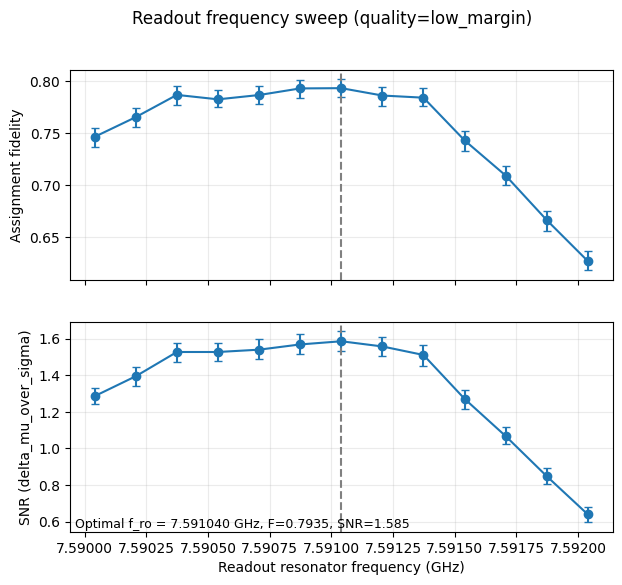

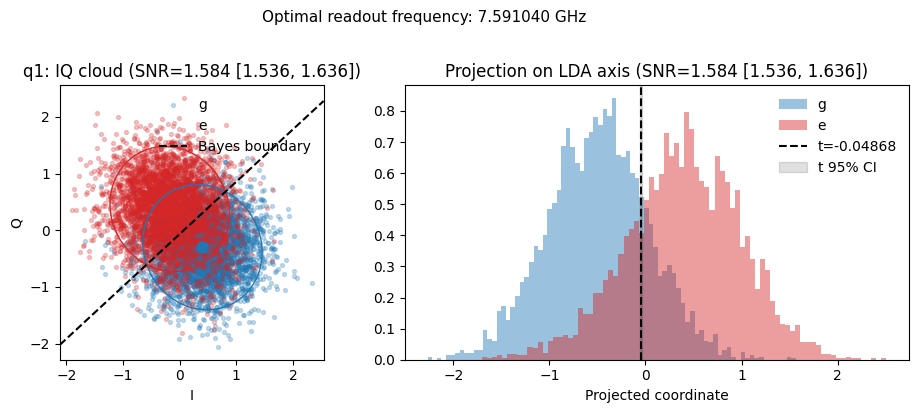

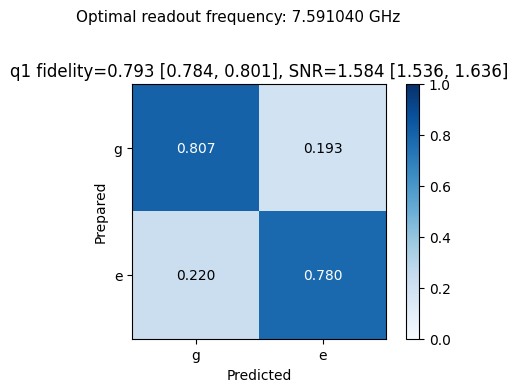

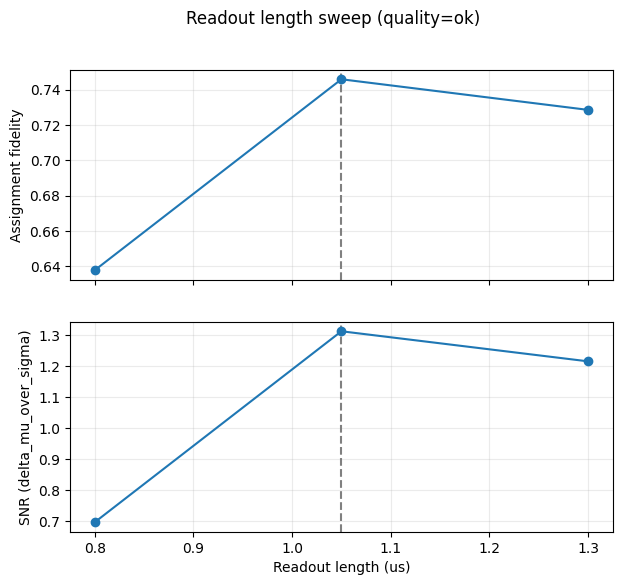

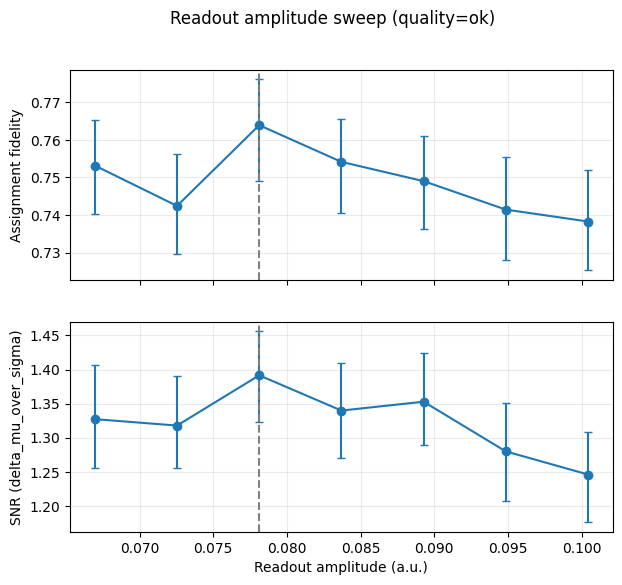

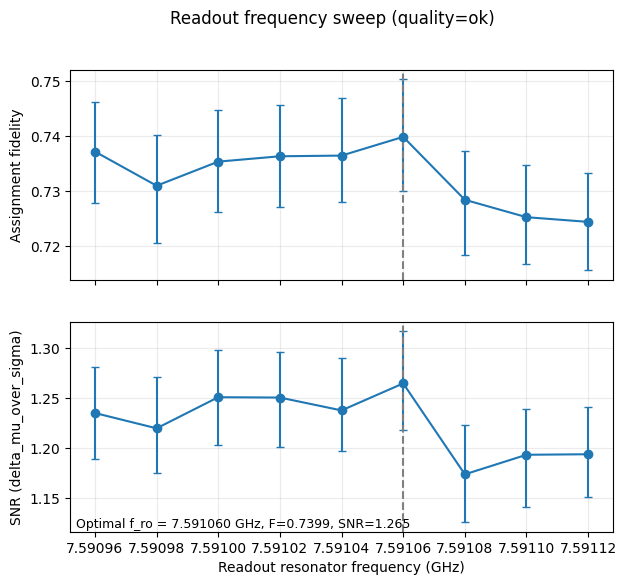

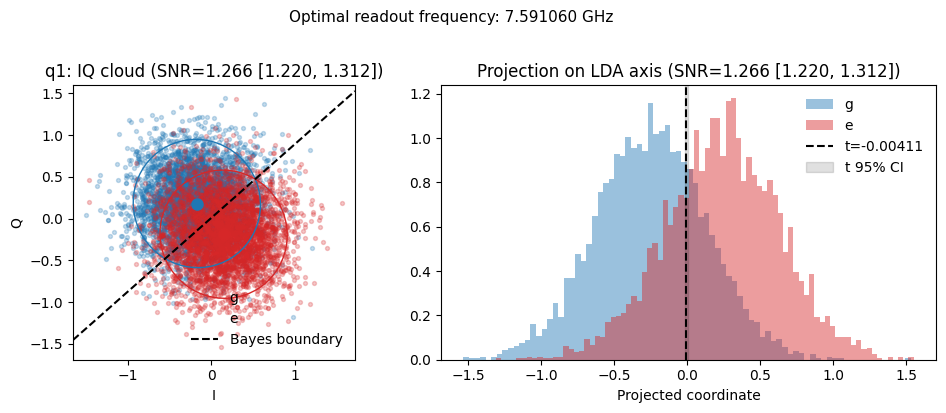

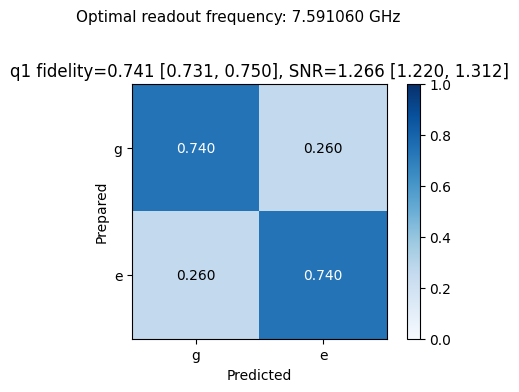

In [15]:
# [READOUT_OPT_V2_RUN]
# Example run
if "qubits" not in globals() or len(qubits) < 1:
    raise RuntimeError("qubits is not available in notebook globals.")

#############################
q_opt = qubits[1]
##########################
init_state = _q_state_from_qubit(q_opt)
if READOUT_OPT_V2_CONFIG.get("init_state_with_max_readout_length", True):
    _max_len = READOUT_OPT_V2_CONFIG.get("max_readout_length")
    if _max_len is not None:
        init_state["readout_length"] = float(_max_len)
        _cap = float(_max_len)
        if _cap <= 0.0:
            raise ValueError("max_readout_length must be positive.")
        init_state["readout_integration_length"] = float(_cap)

result_readout_opt_v2 = run_readout_converged_workflow_v2(
    q=q_opt,
    qpu=qpu,
    session=session,
    state=init_state,
    config=READOUT_OPT_V2_CONFIG,
    do_plot=True,
    plot_iq_cloud=True,
    step_sequence=custom_step_sequence,
    skip_steps=custom_skip_steps,
)

final_readout_state = result_readout_opt_v2["final_state"]
readout_opt_history = result_readout_opt_v2["history"]
readout_opt_diagnostics = result_readout_opt_v2["diagnostics"]

print("final_readout_state:")
pprint(final_readout_state)
print("\ndiagnostics:")
pprint(readout_opt_diagnostics)
print("\nhistory:")
_print_history(readout_opt_history)



In [12]:
final_readout_state

{'readout_resonator_frequency': 7002160000.000001,
 'readout_integration_delay': 1.685e-07,
 'readout_integration_length': 1.65e-06,
 'readout_length': 1.8e-06,
 'readout_amplitude': 0.256}

In [13]:
# [READOUT_OPT_V2_PERSIST]
# Optional: apply optimized state to in-memory qpu object before SAVE QPU cell.
apply_readout_state_to_qpu = True

if apply_readout_state_to_qpu:
    for _k, _v in final_readout_state.items():
        if hasattr(q_opt.parameters, _k):
            setattr(q_opt.parameters, _k, _v)
            
    print(f"Applied optimized readout state to {q_opt.uid} in current qpu object.")
else:
    print("apply_readout_state_to_qpu=False (no parameter mutation applied).")


Applied optimized readout state to q0 in current qpu object.


In [ ]:
qubits[0].parameters.readout_integration_delay

In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
#q_temp_pars.readout_integration_delay = 180e-9
temporary_parameters[q.uid] = q_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
options.count(1024*4)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    temporary_parameters=temporary_parameters,
    options=options,
).run()


In [ ]:
qubits[0].readout_integration_parameters()

# IQ time-trace

In [ ]:
import importlib
import analysis.iq_time_trace as a_iqt
import experiments.iq_time_trace as e_iqt
from IPython.display import display

importlib.reload(a_iqt)
importlib.reload(e_iqt)

###################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

#temp_pars.readout_resonator_frequency = 7.0021e9
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
print(q.readout_parameters())
#######################################################################
opts = e_iqt.experiment_workflow.options()
#options.count(2**14)
opts.do_analysis(True)
opts.apply_software_demodulation(False)
opts.apply_lpf_after_demodulation(False)
opts.count(1024*7)
opts.lpf_cutoff_frequency_hz(25e6)
opts.find_flat_window(True)
#opts.update(True)


#print(workflow.show_fields(options))

###################################################################
iq_t = e_iqt.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=opts,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_trace_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
display(iq_trace_result.tasks['analysis_workflow'].tasks['plot_iq_time_traces'].output[q.uid])
try:
    display(iq_trace_result.tasks['analysis_workflow'].tasks['plot_iq_dsp'].output[q.uid])
    display(iq_trace_result.tasks['analysis_workflow'].tasks['plot_flat_window_debug'].output[q.uid])
except KeyError:
    pass


In [ ]:
fw = iq_trace_result.tasks["analysis_workflow"].output["flat_window_detection"][q.uid]
print(fw["expected_length_samples"], fw["allowed_min_sep_samples"], fw["allowed_max_sep_samples"])


In [ ]:
iq_trace_result.tasks['analysis_workflow'].output["new_parameter_values"]

# SAVE QPU

In [14]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "readout_optv2"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}") 

